In [196]:
import pandas as pd
from tensorflow import keras

In [189]:
def preprocess_images(dir, subset, image_size):
    '''
    Uses the built-in keras image_dateset_from_directiory function to import, resize,
    shuffle, split, and label the database according to the parameters. The seed, set
    at 313, is arbitrary, but is necessary to ensure no overlap between the training
    and testing datasets
    '''
    imgs = keras.utils.image_dataset_from_directory(
        dir,
        subset=subset,
        labels='inferred',
        label_mode='binary',
        class_names=None,
        color_mode='grayscale',
        batch_size=16,
        seed=313,
        image_size=image_size,
        shuffle=True,
        validation_split=0.1,
        interpolation='bilinear',
)

    return imgs

In [190]:
from matplotlib import pyplot as plt

# Set dataset directory and split into the training and testing datasets.
dir = 'datasets/brain_mri_scan_images'
image_size = (128, 128)

train_ds = preprocess_images(dir, 'training', image_size)
test_ds = preprocess_images(dir, 'validation', image_size)

# Optional visualization to ensure the dataset imported properly

# class_names = train_ds.class_names
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     print(f'Labels = {int(labels[i])}')
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
#     plt.title(class_names[int(labels[i])] + str(int(labels[i])))
#     plt.axis("off")



Found 216 files belonging to 2 classes.
Using 195 files for training.
Found 216 files belonging to 2 classes.
Using 21 files for validation.


In [191]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, RandomFlip
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input, concatenate
from keras.layers.core import Dropout, Lambda

# Takes in the input as a 128 x 128 image from the image size variable
inputs = Input((image_size[0], image_size[1], 1))

# Normalizes all input dimensions by dividing by 1
s = Lambda(lambda x: x / 255) (inputs)

# Randomly flips ~50% of the data to help improve the parameters
pp_1 = RandomFlip('horizontal') (s)

# U-Net Architecture, taken from the coding tutorial 6

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pp_1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

f1 = Flatten() (c9)

outputs = Dense(1, activation="sigmoid") (f1)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')



In [192]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

csvlogger = CSVLogger('log.csv')


callbacks_list = [earlystopper, checkpoint, csvlogger]


model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_24 (Lambda)             (None, 128, 128, 1)  0           ['input_25[0][0]']               
                                                                                                  
 random_flip_24 (RandomFlip)    (None, 128, 128, 1)  0           ['lambda_24[0][0]']              
                                                                                                  
 conv2d_432 (Conv2D)            (None, 128, 128, 16  160         ['random_flip_24[0][0]']  

In [193]:
batch_size = 16
epochs = 40

history = model.fit(train_ds, validation_data=test_ds, batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks_list)

Epoch 1/40


12/13 [==========================>...] - ETA: 0s - loss: 8.8496 - accuracy: 0.5833 
Epoch 1: val_loss improved from inf to 15.77635, saving model to model.h5
13/13 [==============================] - 2s 80ms/step - loss: 8.7134 - accuracy: 0.5897 - val_loss: 15.7763 - val_accuracy: 0.4286
Epoch 2/40
13/13 [==============================] - ETA: 0s - loss: 3.5044 - accuracy: 0.6821
Epoch 2: val_loss improved from 15.77635 to 2.96457, saving model to model.h5
13/13 [==============================] - 1s 56ms/step - loss: 3.5044 - accuracy: 0.6821 - val_loss: 2.9646 - val_accuracy: 0.7143
Epoch 3/40
13/13 [==============================] - ETA: 0s - loss: 1.5063 - accuracy: 0.7590
Epoch 3: val_loss improved from 2.96457 to 1.32371, saving model to model.h5
13/13 [==============================] - 1s 56ms/step - loss: 1.5063 - accuracy: 0.7590 - val_loss: 1.3237 - val_accuracy: 0.8095
Epoch 4/40
13/13 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8974
Epoch 4: val_l

In [194]:
import os
import re

# All this code is to check if the new, best model beats the existing best in both val_loss and accuracy, and replaces the
# best-model model if it does

mvl_index = history.history['val_loss'].index(min(history.history['val_loss']))
min_val_loss = round(history.history['val_loss'][mvl_index], 4)
val_accuracy = round(history.history['val_accuracy'][mvl_index], 4)

print(history.history['val_loss'])
print(f'Index = {mvl_index}, Val_Loss = {min_val_loss}, Val_Acc = {val_accuracy}')

for file in os.listdir('.'):
    if file.endswith('.h5') and file.startswith('model-best'):
        best_val_loss, best_val_accuracy = re.findall('\d+\.\d+', file)
        print(best_val_loss, best_val_accuracy)


if min_val_loss < float(best_val_loss) and val_accuracy > float(best_val_accuracy):
    best_model = f'model-best ({best_val_loss} - {best_val_accuracy}).h5'
    new_model = f'model-best ({min_val_loss} - {val_accuracy}).h5'

    print(best_model, new_model)

    os.rename('model.h5', new_model)
    os.remove(best_model)

    os.remove('log-best.csv')
    os.rename('log.csv', 'log-best.csv')


[15.776347160339355, 2.964573621749878, 1.323712706565857, 1.1190996170043945, 1.7994273900985718, 0.9684255719184875, 0.8468292951583862, 0.5038547515869141, 0.709752082824707, 0.8316628336906433, 0.6316357851028442, 0.7343470454216003, 0.6668282747268677]
Index = 7, Val_Loss = 0.5039, Val_Acc = 0.9048
0.4147 0.8571


Text(0, 0.5, 'Validation Loss')

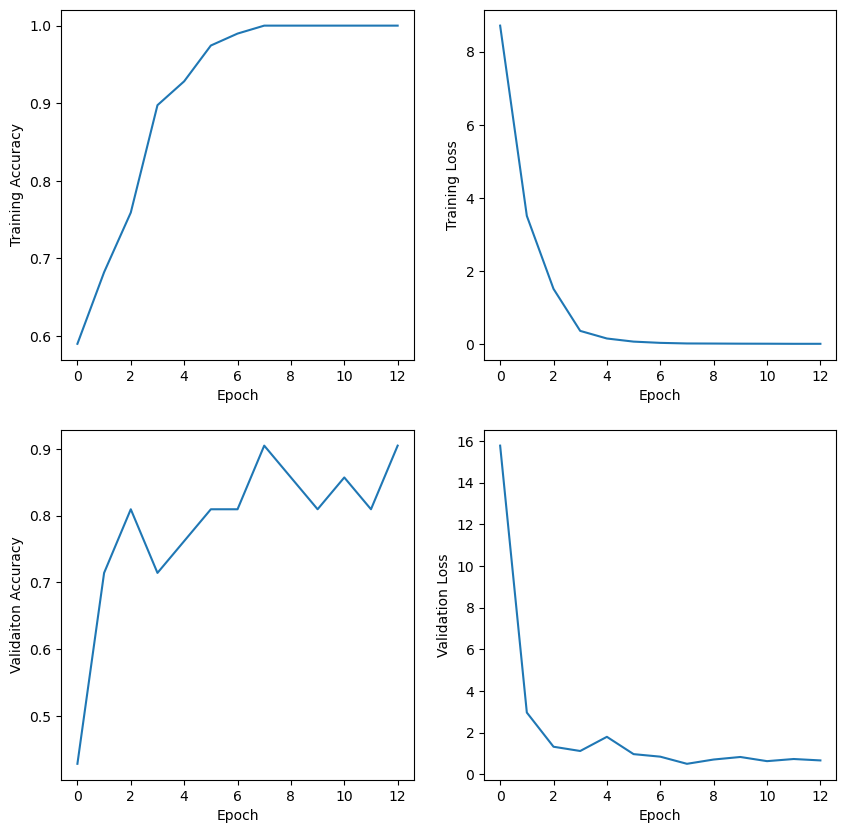

In [204]:
output = pd.read_csv('log-best.csv')
# print(output.head())

plt.figure(1, figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(output['epoch'], output['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(output['epoch'], output['loss'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

plt.subplot(2, 2, 3)
plt.plot(output['epoch'], output['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Validaiton Accuracy')

plt.subplot(2, 2, 4)
plt.plot(output['epoch'], output['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')

